In this sample analysis notebook, we will analysis the data from the Crab pulsar as observed with LAXPC
We will extract the lightcurves, powerspectrum and pulse profile of the pulsar. 

A typical LAXPC observation has data from 3 detectors LAXPC 1-3 and for each detector (also called units), the photons are detected on multiple layers. 
For faint sources, it is advisable to extract data from layer 1 as it has the least contribution from the background events. 

The notebook is designed for LAXPC observation processed using Format (A) software as available on [AstroSat Science support cell](http://astrosat-ssc.iucaa.in/laxpcData). A tutorial for processing the LAXPC data can be found [here](http://astrosat-ssc.iucaa.in/uploads/threadsPageNew_SXT.html)

## Imports 

In [1]:
import stingray
from stingray import EventList, Powerspectrum, AveragedPowerspectrum
from astropy.io import fits
import matplotlib.pyplot as plt

## Loading the event file. 

To proceed further, download the data set from Zenodo and unzip the files. There are two files: 1. Event file and 2. GTI


In [2]:
fpath = "/home/yash/6.Source_data/crab"         # Update this path to the directory where the downloaded and extracted files are kept. 
evt_fname = f"{fpath}/level2.event.fits"
gti_fname = f"{fpath}/usergti.fits"
ev = EventList.read(evt_fname, 'hea', additional_columns=["Layer"])
gti = stingray.gti.load_gtis(gti_fname)
ev.apply_gtis(new_gti=gti)


/home/yash/1.Cagliari/stingray_dev/stingray_git/stingray/io.py:959: UserWarning: HDU EVENTS not found. Trying first extension
  warnings.warn(f"HDU {hduname} not found. Trying first extension")
/home/yash/1.Cagliari/stingray_dev/stingray_git/stingray/io.py:1060: UserWarning: No valid GTI extensions found. 
Error: list index out of range
GTIs will be set to the entire time series.
  warnings.warn(


## Filtering based on Units

In this exercise, we will extract events from individual units, generate lightcurves and plot them. 

/home/yash/1.Cagliari/stingray_dev/stingray_git/stingray/events.py:696: UserWarning: The input event list has a time resolution of 9.99999975e-06. Using a multiple of that as dt (0.999999975).
  warnings.warn(


<Axes: xlabel='Time (s)', ylabel='counts'>

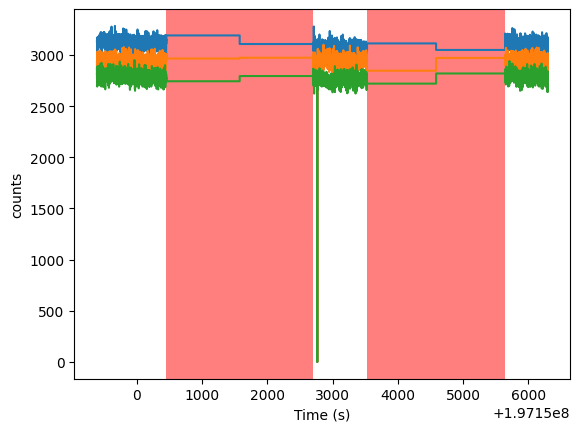

In [3]:
# Filtering the events based on the detector ID
unit1 = ev.filter_detector_id(1)
unit2 = ev.filter_detector_id(2)
unit3 = ev.filter_detector_id(3)

lc_unit1 = unit1.to_lc(dt=1)
lc_unit1.apply_gtis()
lc_unit2 = unit2.to_lc(dt=1)
lc_unit2.apply_gtis()
lc_unit3 = unit3.to_lc(dt=1)
lc_unit3.apply_gtis()


lc_unit1.plot()
lc_unit2.plot(plot_btis=False)
lc_unit3.plot(plot_btis=False)
# plt.show()


Crab is known to be a stable source. So the dip in the lightcurve should be a data drop.  
Let's use stingray to set the minimum count rate and create a new GTI. 

[[1.97149389e+08 1.97150455e+08]
 [1.97152699e+08 1.97152763e+08]
 [1.97152768e+08 1.97153530e+08]
 [1.97155643e+08 1.97156299e+08]]


<Axes: xlabel='Time (s)', ylabel='counts'>

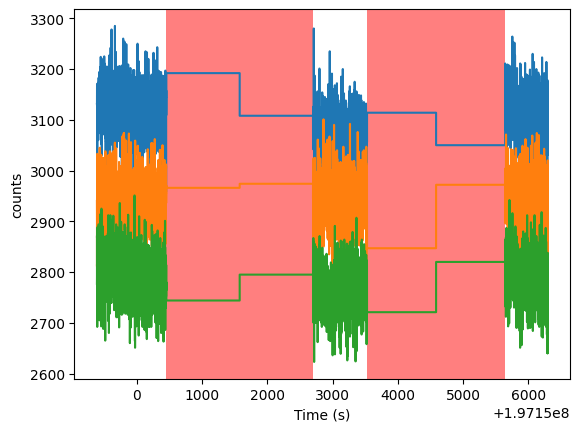

In [4]:
min_counts = 2500
new_gti = stingray.gti.create_gti_from_condition(lc_unit1.time, lc_unit1.counts>min_counts)
merged_gti = stingray.gti.cross_two_gtis(new_gti, gti)
# print (new_gti, gti, merged_gti)

unit1.apply_gtis(merged_gti)
lc_unit1 = unit1.to_lc(dt=1)
lc_unit1.apply_gtis()
lc_unit1.plot()
unit2.apply_gtis(merged_gti)
lc_unit2 = unit2.to_lc(dt=1)
lc_unit2.apply_gtis()
lc_unit2.plot(plot_btis=False)
unit3.apply_gtis(merged_gti)
lc_unit3 = unit3.to_lc(dt=1)
lc_unit3.apply_gtis()
print (lc_unit3.gti)
lc_unit3.plot(plot_btis=False)


Now the light curve for each Unit is well behaved. We also see slightly different count rates in each unit. 

## Filtering based on layer

In this we will extract based on a single layer and all layers for a particular unit and compare the lightcurves

/home/yash/1.Cagliari/stingray_dev/stingray_git/stingray/events.py:696: UserWarning: The input event list has a time resolution of 9.99999975e-06. Using a multiple of that as dt (0.999999975).
  warnings.warn(


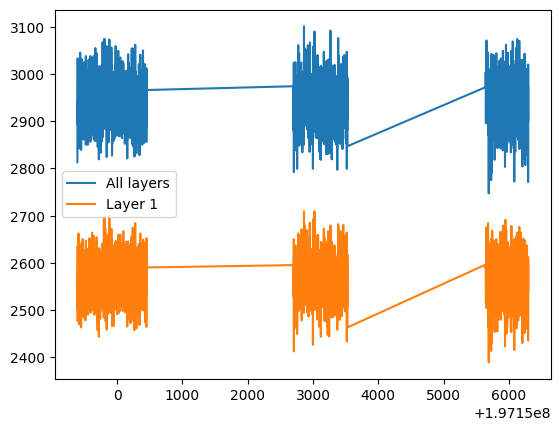

In [7]:
layer1_unit2 = unit2.apply_mask((unit2.layer==1))
lc_layer1_unit2 = layer1_unit2.to_lc(dt=1)
lc_layer1_unit2.apply_gtis()

plt.plot(lc_unit2.time, lc_unit2.counts, label="All layers")
plt.plot(lc_layer1_unit2.time, lc_layer1_unit2.counts, label='Layer 1')
plt.legend()


## Energy dependent lightcurves

Here we will extract energy dependent lightcurves

In [ ]:
unit2_layer1_soft = unit2_layer1.filter_energy_range([6,10])
unit2_layer1_hard = unit2_layer1.filter_energy_range([10,20])
unit2_layer1_full = unit2_layer1.filter_energy_range([3,20])

## Search of pulsations and folding

Since the source we are analysing is a pulsar, we can search for pulsations. Here are some steps for the same

1. Generate a power-density spectrum and look for peaks. 
2. Z^2 search on the data
3. Epoch folding of the best-fit period. 